# Clustering

Video https://youtu.be/ZfSR3pISWWw


1. KMeans
    - How to compare different clusterings
    - How to select k
    - When KMeans fails
2. Hierarchical clustering
3. Density-based clustering (DBSCAN)
4. Spectral Clustering
5. Community detection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#### Mikhail Belyaev and Maxim Panov

Let's start by creating a simple, 2-dimensional, synthetic dataset:

In [2]:
from sklearn.datasets import make_blobs
random_state = 42

X, y = make_blobs(random_state=random_state)
print(X.shape, y)

(100, 2) [2 1 0 1 2 1 0 1 1 0 0 2 2 0 0 2 2 0 2 2 0 2 2 0 0 0 1 2 2 2 2 1 1 2 0 0 0
 0 1 1 2 0 1 0 0 1 2 2 2 1 1 1 0 2 2 2 0 0 1 0 2 1 2 1 2 2 1 2 1 1 1 2 2 0
 1 2 1 2 1 1 0 1 0 2 0 0 0 1 0 1 1 1 0 1 0 0 0 1 2 0]


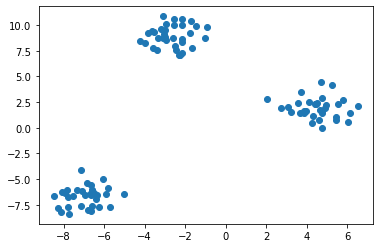

In [3]:
plt.scatter(X[:, 0], X[:, 1]);

* In the scatter plot above, we can see three separate groups of data points and we would like to recover them using clustering.
* Think of "discovering" the class labels that we already take for granted in a classification task.
* Even if the groups are obvious in the data, it is hard to find them when the data lives in a high-dimensional space, which we can't visualize in a single histogram or scatterplot.

# K-means
* Now we will use one of the simplest clustering algorithms, K-means.
* This is an iterative algorithm which searches for three cluster centers such that the distance from each point to its cluster is minimized.
* The standard implementation of K-means uses the Euclidean distance.

**Question:** what would you expect the output to look like?

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=random_state)

* We can get the cluster labels either by calling fit and then accessing the ``labels_`` attribute of the K means estimator, or by calling ``fit_predict``.
* Either way, the result contains the ID of the cluster that each point is assigned to.

In [5]:
kmeans.fit(X)
labels = kmeans.predict(X)

In [6]:
labels

array([1, 0, 2, 0, 1, 0, 2, 0, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 0, 1, 2, 0, 2,
       2, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 2, 0, 2, 1, 2, 2, 2, 0,
       2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 1, 2], dtype=int32)

In [7]:
all(y == labels)

False

Let's visualize the assignments that have been found

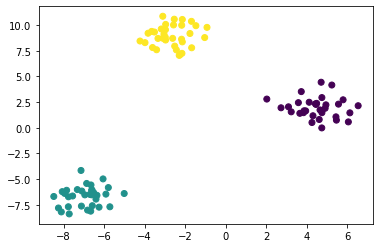

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=labels);

Compared to the true labels:

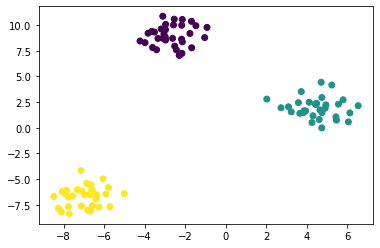

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y);

* Here, we are probably satisfied with the clustering results.
* But in general we might want to have a more quantitative evaluation.
* How about comparing our cluster labels with the ground truth we got when generating the blobs?

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score

print('Accuracy score:', accuracy_score(y, labels))
print(confusion_matrix(y, labels))

Accuracy score: 0.0
[[ 0  0 34]
 [33  0  0]
 [ 0 33  0]]


In [11]:
np.mean(y == labels)

0.0

**Exercise**

After looking at the "True" label array y, and the scatterplot and `labels` above, can you figure out why our computed accuracy is 0.0, not 1.0, and can you fix it?

* Even though we recovered the partitioning of the data into clusters perfectly, the cluster IDs we assigned were arbitrary, and we can not hope to recover them.
* Therefore, we must use a different scoring metric, such as ``adjusted_rand_score``, which is invariant to permutations of the labels:

In [12]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(y, labels)

# Instead of comparing object labels, ARI compares all pairs of objects

1.0

* One of the "short-comings" of K-means is that we have to specify the number of clusters, which we often don't know *apriori*.
* For example, let's have a look what happens if we set the number of clusters to 2 in our synthetic 3-blob dataset:

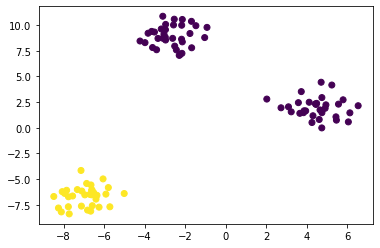

In [13]:
kmeans = KMeans(n_clusters=2, random_state=random_state)
labels = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels);

## The Elbow Method

* The Elbow method is a "rule-of-thumb" approach to finding the optimal number of clusters.
* Here, we look at the cluster dispersion for different values of k:

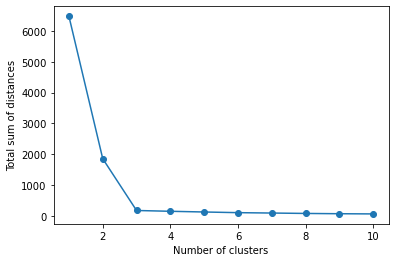

In [14]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Total sum of distances');

Then, we pick the value that resembles the "pit of an elbow." As we can see, this would be k=3 in this case, which makes sense given our visual expection of the dataset previously.

**Clustering comes with assumptions**:
* A clustering algorithm finds clusters by making assumptions with samples should be grouped together.
* Each algorithm makes different assumptions and the quality and interpretability of your results will depend on whether the assumptions are satisfied for your goal.
* For K-means clustering, the model is that all clusters have equal, spherical variance.

**In general, there is no guarantee that structure found by a clustering algorithm has anything to do with what you were interested in**.


# When KMeans fails

### Different variance

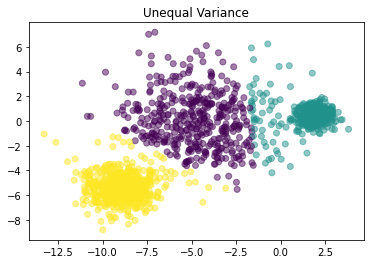

In [15]:
n_samples = 1500
random_state = 170

X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)

kmeans = KMeans(n_clusters=3, random_state=random_state)

labels = kmeans.fit_predict(X_varied)


plt.scatter(X_varied[:, 0], X_varied[:, 1], c=labels, alpha=.5);
plt.title("Unequal Variance");


### Unevenly sized blobs

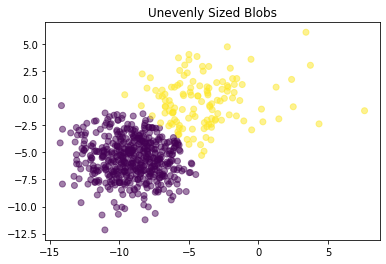

In [16]:
X, y = make_blobs(n_samples=n_samples,
                  cluster_std=[2.0, 2.0, 2.0],
                  random_state=random_state)
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))

kmeans = KMeans(n_clusters=2, random_state=random_state)

labels = kmeans.fit_predict(X_filtered)


plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=labels, alpha=0.5);
plt.title("Unevenly Sized Blobs");


### Anisotropically distributed data

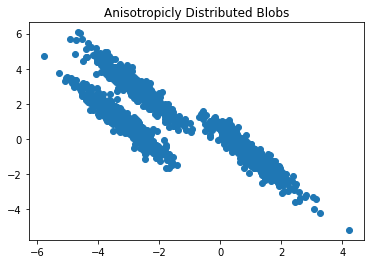

In [17]:
X, y = make_blobs(n_samples=n_samples, cluster_std=[1.0, 1.0, 1.0], random_state=random_state)

transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1]);
plt.title("Anisotropicly Distributed Blobs");

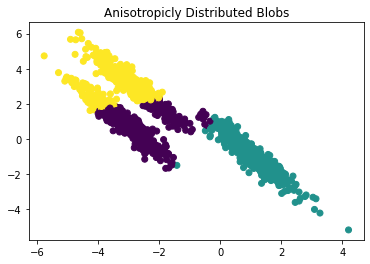

In [18]:
kmeans = KMeans(n_clusters=3, random_state=random_state)

labels = kmeans.fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=labels);
plt.title("Anisotropicly Distributed Blobs");

### GMM for anysotropic clusters

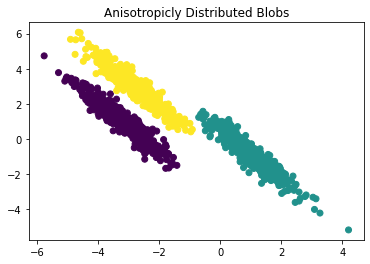

In [19]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=random_state)

gmm.fit(X_aniso)

y_pred = gmm.predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred);
plt.title("Anisotropicly Distributed Blobs");


# Notable Clustering Routines

The following are two well-known clustering algorithms. 

- `sklearn.cluster.KMeans`: <br/>
    The simplest, yet effective clustering algorithm. Needs to be provided with the
    number of clusters in advance, and assumes that the data is normalized as input
    (but use a PCA model as preprocessor).
- `sklearn.cluster.MeanShift`: <br/>
    Can find better looking clusters than KMeans but is not scalable to high number of samples.
- `sklearn.cluster.DBSCAN`: <br/>
    Can detect irregularly shaped clusters based on density, i.e. sparse regions in
    the input space are likely to become inter-cluster boundaries. Can also detect
    outliers (samples that are not part of a cluster).
- `sklearn.cluster.AffinityPropagation`: <br/>
    Clustering algorithm based on message passing between data points.
- `sklearn.cluster.SpectralClustering`: <br/>
    KMeans applied to a projection of the normalized graph Laplacian: finds
    normalized graph cuts if the affinity matrix is interpreted as an adjacency matrix of a graph.
- `sklearn.cluster.Ward`: <br/>
    Ward implements hierarchical clustering based on the Ward algorithm,
    a variance-minimizing approach. At each step, it minimizes the sum of
    squared differences within all clusters (inertia criterion).

Of these, Ward, SpectralClustering, DBSCAN and Affinity propagation can also work with precomputed similarity matrices.

<img src="figures/cluster_comparison.png" width="900">

## Exercise: digits clustering

* Perform K-means clustering on the digits data, searching for ten clusters.
* Visualize the cluster centers as images (i.e. reshape each to 8x8 and use ``plt.imshow``)
* Do the clusters seem to be correlated with particular digits?
* What is the ``adjusted_rand_score``?


In [20]:
from sklearn.datasets import load_digits

In [21]:
digits = load_digits(n_class=10)
digits.data.shape

(1797, 64)

In [22]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(digits.data)

print(kmeans.cluster_centers_.shape)

(10, 64)


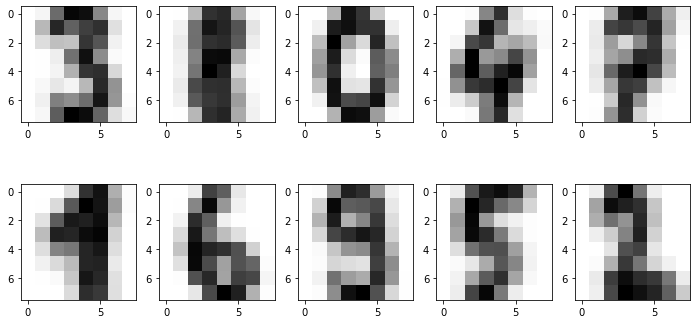

In [23]:
fig = plt.figure(figsize=(12, 6))

for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i)
    ax.imshow(kmeans.cluster_centers_[i].reshape((8, 8)), cmap='binary')

In [24]:
adjusted_rand_score(clusters, digits.target)

0.6724127164998243

# Hierarchical Clustering

* One nice feature of hierachical clustering is that we can visualize the results as a dendrogram, a hierachical tree.
* Using the visualization, we can then decide how "deep" we want to cluster the dataset by setting a "depth" threshold
* Or in other words, we don't need to make a decision about the number of clusters upfront.


## Agglomerative and divisive hierarchical clustering

* Furthermore, we can distinguish between 2 main approaches to hierarchical clustering: Divisive clustering and agglomerative clustering.
* In agglomerative clustering, we start with a single sample from our dataset and iteratively merge it with other samples to form clusters - we can see it as a bottom-up approach for building the clustering dendrogram.  
* In divisive clustering, however, we start with the whole dataset as one cluster, and we iteratively split it into smaller subclusters - a top-down approach.  

In this notebook, we will use **agglomerative** clustering.

### Single and complete linkage

* Now, the next question is how we measure the similarity between samples.
* One approach is the familiar Euclidean distance metric that we already used via the K-Means algorithm. 
* As a refresher, the distance between 2 m-dimensional vectors $\mathbf{p}$ and $\mathbf{q}$ can be computed as:

\begin{align} \mathrm{d}(\mathbf{q},\mathbf{p}) & = \sqrt{(q_1-p_1)^2 + (q_2-p_2)^2 + \cdots + (q_m-p_m)^2} \\[8pt]
& = \sqrt{\sum_{j=1}^m (q_j-p_j)^2}.\end{align}	

* However, that's the distance between 2 samples.
* Now, how do we compute the similarity between subclusters of samples?
* I.e., our goal is to iteratively merge the most similar pairs of clusters until only one big cluster remains.
* There are many different approaches to this, for example single and complete linkage.

* In single linkage, we take the pair of the most similar samples (based on the Euclidean distance, for example) in each cluster, and merge the two clusters which have the most similar 2 members into one new, bigger cluster.
* In complete linkage, we compare the pairs of the two most dissimilar members of each cluster with each other, and we merge the 2 clusters where the distance between its 2 most dissimilar members is smallest.

![](figures/clustering-linkage.png)

In [25]:
from sklearn import datasets

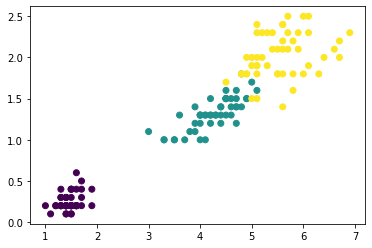

In [26]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
n_samples, n_features = X.shape

plt.scatter(X[:, 0], X[:, 1], c=y);

In [27]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [28]:
clusters = linkage(X, metric='euclidean', method='complete')

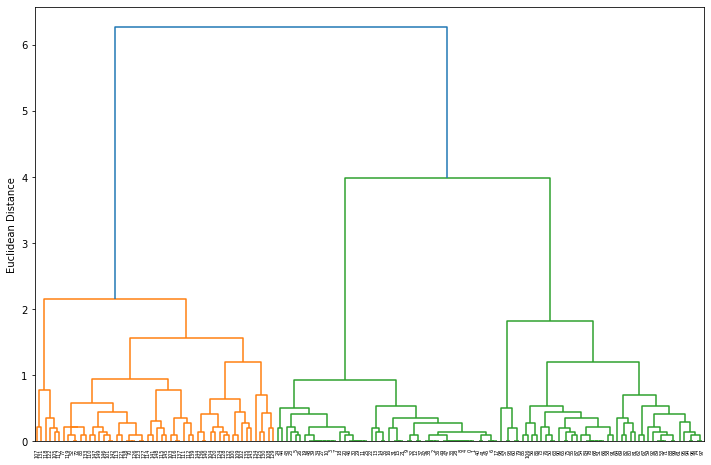

In [29]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
dendr = dendrogram(clusters, ax=ax)

plt.ylabel('Euclidean Distance');

In [30]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean',
                             linkage='complete')

prediction = ac.fit_predict(X)
print('Cluster labels: %s\n' % prediction)

Cluster labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]



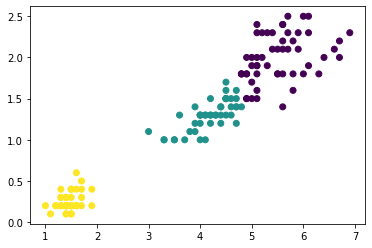

In [31]:
plt.scatter(X[:, 0], X[:, 1], c=prediction);

# Density-based Clustering - DBSCAN

https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

* Another useful approach to clustering is *Density-based Spatial Clustering of Applications with Noise* (DBSCAN).
* In essence, we can think of DBSCAN as an algorithm that divides the dataset into subgroup based on dense regions of points.

In DBSCAN, we distinguish between 3 different "points":

- Core points: A core point is a point that has at least a minimum number of other points (MinPts) in its radius epsilon.
- Border points: A border point is a point that is not a core point, since it doesn't have enough MinPts in its neighborhood, but lies within the radius epsilon of a core point.
- Noise points: All other points that are neither core points nor border points.

![](figures/dbscan.png)

A nice feature about DBSCAN is that we don't have to specify a number of clusters upfront. However, it requires the setting of additional hyperparameters such as the value for MinPts and the radius epsilon.

In [32]:
from sklearn.datasets import make_moons

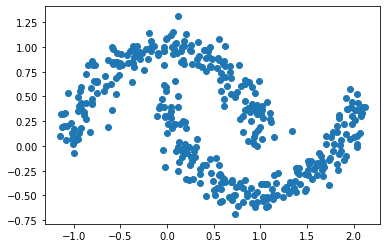

In [33]:
X, y = make_moons(n_samples=400, noise=0.1, random_state=1)
plt.scatter(X[:,0], X[:,1]);

In [34]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
labels = db.fit_predict(X)
labels[:10]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0])

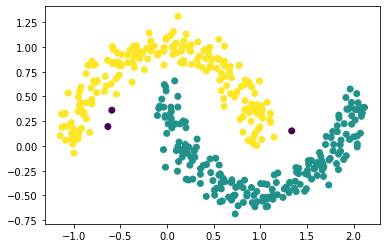

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=labels);

## Exercise

* Using the following toy datasets, two concentric circles, experiment with the three different clustering algorithms that we used so far `KMeans`, `AgglomerativeClustering`, and `DBSCAN`.
* Which clustering algorithms reproduces or discovers the hidden structure (pretending we don't know `y`) best?
* Can you explain why this particular algorithm is a good choice while the other 2 "fail"?

In [36]:
from sklearn.datasets import make_circles

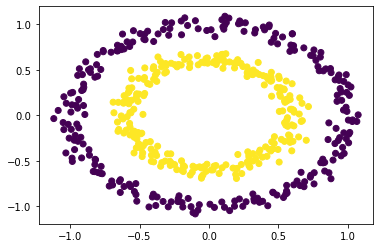

In [37]:
X, y = make_circles(n_samples=500, factor=.6, noise=.05)

plt.scatter(X[:, 0], X[:, 1], c=y);

# Spectral clustering

In [38]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

In [39]:
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0])**2 + (y - center1[1])**2 < radius1**2
circle2 = (x - center2[0])**2 + (y - center2[1])**2 < radius2**2
circle3 = (x - center3[0])**2 + (y - center3[1])**2 < radius3**2
circle4 = (x - center4[0])**2 + (y - center4[1])**2 < radius4**2

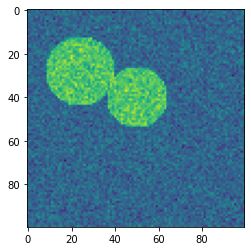

In [40]:
# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

plt.imshow(img)

In [41]:
img.shape

(100, 100)

In [42]:
10000

10000

In [43]:
graph = image.img_to_graph(img, mask=mask)

# Graph of the pixel-to-pixel gradient connections

# Edges are weighted with the gradient values.

# Pixel-to-Pixel graph with edges = distance between pixel intesities

In [44]:
graph

<1394x1394 sparse matrix of type '<class 'numpy.float64'>'
	with 6760 stored elements in COOrdinate format>

In [45]:
graph.data.shape

(6760,)

In [46]:
1394*1394

1943236

In [47]:
# Less distant = More similar

graph.data = np.exp(-graph.data / graph.data.std())

Instead of working with Object x Features matrix, Spectral clustering can work with affinity matrix

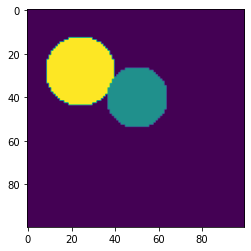

In [48]:
labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.imshow(label_im);

In [49]:
labels.shape

(1394,)

# Community detection

In [50]:
import community
import networkx as nx

## Karate club

In [51]:
#loading karate club graph

G = nx.karate_club_graph()

In [52]:
G

In [53]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

In [54]:
G.edges

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)])

In [55]:
len(G.edges)

78

In [56]:
adj = nx.adj_matrix(G).todense()

In [57]:
adj.shape

(34, 34)

In [58]:
#first compute the best partition

partition = community.best_partition(G)
partition = list(partition.values())

print(partition)

[0, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0, 2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2]


In [59]:
# drawing

pos = nx.layout.spring_layout(G)
pos = np.array(list(pos.values()))

pos.shape

(34, 2)

In [60]:
print(pos[:5])

[[ 0.42594564  0.19724147]
 [ 0.35246599 -0.14838017]
 [ 0.03476853 -0.07311966]
 [ 0.40594619  0.05084569]
 [ 0.51732321  0.6462635 ]]


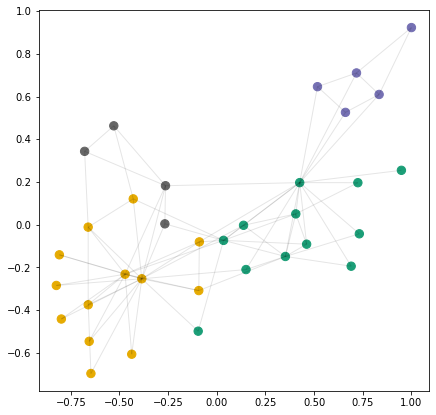

In [61]:
plt.figure(figsize=(7,7))
plt.scatter(pos[:, 0], pos[:,1], c=partition, cmap='Dark2', s=70)
nx.draw_networkx_edges(G, pos, alpha=0.1);

In [62]:
partition = community.best_partition(G)
print(community.modularity(partition, G))

0.41978961209730437


## Facebook ego networks

In [63]:
G_fb = nx.read_edgelist("data/facebook_combined.txt", create_using = nx.Graph(), nodetype = int)

In [64]:
# Quick snapshot of the Network

print(nx.info(G_fb))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


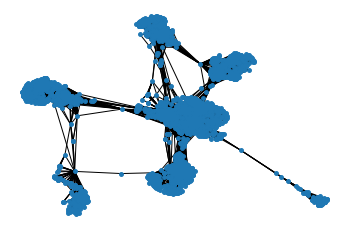

In [65]:
#Create network layout for visualizations

spring_pos = nx.layout.spring_layout(G_fb)

plt.axis("off")
nx.draw_networkx(G_fb, pos=spring_pos, with_labels=False, node_size=15)

In [66]:
#find best partition

parts = community.best_partition(G_fb)
values = [parts.get(node) for node in G_fb.nodes()]

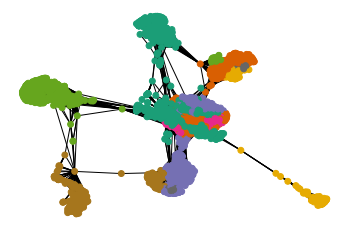

In [67]:
#drawing

plt.axis("off")
nx.draw_networkx(G_fb, pos=spring_pos, cmap=plt.get_cmap("Dark2"),
                 node_color=values, node_size=35, with_labels=False)

In [68]:
print(community.modularity(parts, G_fb))

0.8348111204670676
